In [ ]:
import os
import struct
import torch
import sys
import pickle
import math
import threading
import time
import torch.nn as nn
import torch.nn.functional as F
import syft as sy
import numpy as np
import random as rd

from torch.nn import Parameter
from numpy import random as rdm
from phe import paillier
# from Pyfhel import Pyfhel, PyPtxt, PyCtxt



# 创建Pi，P1-i两个参与方并且互作host与guest

hook = sy.TorchHook(torch)
# print(hook)

# P0 = sy.VirtualWorker(hook, id='guest')
# print('Pi = ', Pi) == local
P1 = sy.VirtualWorker(hook, id='host')
# print('P1-i = ', P1_i)



# p = 一个长为lbit位的大素数（要不取512bit？）

def proBin(w):  # w表示希望产生位数
    list = []
    list.append(1)  #最高位定为1
    for i in range(w - 2):
        c = randint(0, 1)
        list.append(c)
    list.append(1)
    ls2 = [str(j) for j in list]
    ls3 = ''.join(ls2)
    b = int(ls3[0])
    for i2 in range(len(ls3) - 1):
        b = b << 1
        b = b + int(ls3[i2 + 1])
    d = int(b)
    return d

def X_n_mod_P(x, n, p):  # x^n mod P 递归求法 (x*x)^(n/2) mod P = ((x*x)mod P)^(n/2) mod P
    if n == 0:
        return 1
    res = X_n_mod_P((x * x) % p, n >> 1, p)
    if n & 1 != 0:
        res = (res * (x)) % p # x是较小数，x%p的结果就是本身
    return res

def MillerRabin(a, p):
    if X_n_mod_P(a, p - 1, p) == 1:
        u = (p-1) >> 1
        while (u & 1) == 0:
            t = X_n_mod_P(a, u, p)
            if t == 1:
                u = u >> 1
            else:
                if t == p - 1:
                    return True
                else:
                    return False
        else:
            t = X_n_mod_P(a, u, p)
            if t == 1 or t == p - 1:
                return True
            else:
                return False
    else:
        return False

def testMillerRabin(p, k):  # k为测试次数，p为待测奇数
    while k > 0:
        a = randint(2, p - 1)
        if not MillerRabin(a, p):
            return False
        k = k - 1
    return True


def pro512():   # 产生512位素数
    while 1:
        d = proBin(512)
        for i in range(50):  # 伪素数附近50个奇数都没有真素数的话，重新再产生一个伪素数
            u = testMillerRabin(d + 2 * i, 5)
            if u:
                b = d + 2 * i
                break
            else:
                continue
        if u:
            return b
        else:
            continue


            
def RandomMatrix(m, n, p):  # 参生GF（p）内的随机矩阵
    Mat = []
    for i in range (0, m):
        Mat.append([])
    for i in range (0, m):
        for j in range (0, n):
            Mat[i].append(j)
            Mat[i][j] = 0
            Mat[i][j] = rd.randint(0, p)
    
    return Mat

def Mod(Mat, p):  # GF（p）
    row_len = len(Mat)
    column_len = len(Mat[0])
    mod_mat = [[0] * column_len for i in range(row_len)]
    for i in range (row_len):
        for j in range (column_len):
            mod_mat[i][j] = Mat[i][j] % p
    
    return mod_mat

def Mul(A, B):  # 矩阵乘法
    row_len = len(A)
    column_len = len(B[0])
    cross_len = len(B)
    mul_mat = [[0] * column_len for i in range(row_len)]
    for i in range(row_len):
        for j in range(column_len):
            for k in range(cross_len):
                temp = (A[i][k] * B[k][j])
                mul_mat[i][j] = (temp + mul_mat[i][j])
            
    return mul_mat

def NumMul(num, Mat):  # 矩阵乘法
    for i in range(len(Mat)):
        for j in range(len(Mat[0])):
            Mat[i][j] = Mat[i][j] * num
            
    return Mat

def Add(A, B):  # 矩阵加法
    add_mat = [[0] * len(A[0]) for i in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A[0])):
            add_mat[i][j] = (A[i][j] + B[i][j])
        
    return add_mat

def Sub(A, B, p):  # 矩阵模减
    sub_mat = [[0] * len(A[0]) for i in range(len(A))]
    for i in range(len(A)):
        for j in range(len(A[0])):
            sub_mat[i][j] = (A[i][j] - B[i][j]) % p
        
    return sub_mat

def Resize(Mat, m, n):  # 一维恢复
    resize_mat = []
    for i in range (m):
        resize_mat.append(Mat[(i * n) : ((i + 1) * n)])
    
    return resize_mat

def TransM(Mat):
    trasm_mat = []
    
    for i in range(len(Mat[0])):
        temp = []
        for j in range(len(Mat)):
            temp.append(Mat[j][i])
        trasm_mat.append(temp)
    
    return trasm_mat

def Sum(Mat):
    s = 0
    for i in range (len(Mat[0])):
        s = s + Mat[0][i]
        
    return s



def Sigmoid(Mat):
    s = [[0] * len(Mat[0]) for i in range(len(Mat))]
    for i in range (len(Mat)):
        for j in range (len(Mat[0])):
            s[i][j] = (1 / (1 + math.exp(-Mat[i][j])))
    
    return s



# p = 65537
# p = pro512()
# print(pro512())



# Algorithm 1 Matrix SS Input

# Pi 输入矩阵 X ∈ [m, n]

# X = Matrix(GF(pro512()), [[1, 1], [1, 0]])  # 秘密值输入

# X = Mod(eval(input("Please input your matrix in mxn:\n")), p)

# X = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]

# y = [[1, 2]]

# m = len(X)

# n = len(X[0])

# k = len(y[0])

def Input(X, p):
    m = len(X)
    n = len(X[0])
    
    # RandomM = random_matrix(GF(pro512()), m, n)
    # RM = rdm.random(size=(m, n)) * rd.randint(0, p + 1) # 发送给 P1−i，这个是∈R
    
    RandomM = RandomMatrix(m, n, p)  # 发送给 P1−i，这个是∈Z
    X1_ptr = torch.tensor(RandomM).send(P1)  # P1-i的操作, 返回P1-i， 本地不可见
    # X1_ptr = RandomM.send(P1)  # P1-i的操作, 返回P1-i， 本地不可见
    
    X0 = Sub(X, RandomM, p)  # 返回Pi，留在local
    # X1_i = RandomM_ptr  # P1-i的操作, 返回P1-i
    
    return X0, X1_ptr

# Input(X)



# Algorithm 2 x′ = Matrix SS Output

# Pi发送Xi给P1-i， P1-i输入X1_i进行计算

def Output(X0, X1_ptr, p):
    X1 = [[0] * len(X1_ptr[0]) for i in range(len(X1_ptr))]
    for i in range (len(X1_ptr)):
        for j in range (len(X1_ptr[0])):
            X1[i][j] = float(X1_ptr[i][j].get())
            
    # X1 = X1_ptr.get().tolist()
    
    # X_ptr = torch.tensor()
    X_ = Mod(Add(X0, X1), p)  # Pi发送计算后模型X_给P1-i
    
    return X_

def Output1(X0, X1_ptr, p):
    X0_ptr = torch.tensor(X0).send(P1)
    X_ptr = Mod(Add(X0_ptr, X1_ptr), p)  # Pi发送计算后模型X_给P1-i
    
    return X_ptr



# Xi = Matrix(GF(7), [[6, 6], [6, 6]])
# X1_i = Matrix(GF(7), [[6, 6], [6, 6]])  # 其实说到底有限域就是把计算限制在[0， p - 1]内， 就是个mod运算
# Output(Xi, X1_i)



# Algorithm 3 HE 生成矩阵 MTMT

# y = Mod(eval(input("Please input your y matrix in 1xk:\n")), p)

# y = [[1, 2]]

# k = len(y[0])



def MTMT(m, n, k, p):
    public_key, private_key = paillier.generate_paillier_keypair()
    
    # print(public_key)
    # print(private_key)
    
    A0 = RandomMatrix(m, n, p)
    B0 = RandomMatrix(n, k, p)
    
    # print('A0:', A0)
    # print('B0:', B0)
    
    EA0 = []
    EB0 = []
    
    for i in range (len(A0)):
        for j in range (len(A0[0])):
            EA0.append(public_key.encrypt(A0[i][j]))
    
    for i in range (len(B0)):
        for j in range (len(B0[0])):
            EB0.append(public_key.encrypt(B0[i][j]))
            
    # print('EA0:', EA0)
    
    def MTMT1(m, n, k, p, public_key, EA0, EB0):
        A1 = RandomMatrix(m, n, p)
        B1 = RandomMatrix(n, k, p)
        R = RandomMatrix(m, k, p)
        
        # print('A1:', A1)
        # print('B1:', B1)
        
        A1_ptr = torch.tensor(A1).send(P1)
        B1_ptr = torch.tensor(B1).send(P1)
        R_ptr = torch.tensor(R).send(P1)
        # print('A1_ptr:', type(A1_ptr))
        
        ER = []
        
        for i in range (len(R)):
            for j in range (len(R[0])):
                ER.append(public_key.encrypt(R[i][j]))
                
        # ER_ = pickle.dumps(ER)
        # ER_ptr = torch.tensor(ER_).send(P1)
        
        ED = Add(Add(Mul(Resize(EA0, m, n), B1), 
                     Mul(A1, Resize(EB0, n, k))), Resize(ER, m, k)) 
        C1_ptr = torch.tensor(Sub(Mul(A1, B1), R, p)).send(P1)
        
        
        
        return ED, A1_ptr, B1_ptr, C1_ptr
    
    ED, A1_ptr, B1_ptr, C1_ptr = MTMT1(m, n, k, p, public_key, EA0, EB0)
    
    '''
    A1 = A1_ptr.get().tolist()
    B1 = B1_ptr.get().tolist()
    C1 = C1_ptr.get().tolist()
    '''
    
    # print('A1:', A1)
    
    DD = []
    
    for i in range (len(ED)):
        for j in range (len(ED[0])):
            DD.append(private_key.decrypt(ED[i][j]))
    
    D = Resize(DD, m, k)
    # print('C0:', Add(D, Mul(A0, B0)))
    C0 = Mod(Add(D, Mul(A0, B0)), p)
    
    '''
    print('C0 + C1:', Mod(Add(C0, C1), p))
    # print('A0+A1:', Add(A0, A1))
    # print('B0+B1:', Add(B0, B1))
    # print('other:', Mul(Add(A0, A1), Add(B0, B1)))
    print('Another:', Mod(Mul(Add(A0, A1), Add(B0, B1)), p))
    '''
    
    return A0, B0, C0, A1_ptr, B1_ptr, C1_ptr



# Algorithm 4 Matrix Multiplication SS

def MultSS(X0, Y0, X1_ptr, Y1_ptr, A0, B0, C0, A1_ptr, B1_ptr, C1_ptr, p):
    '''
    A1 = A1_ptr.get().tolist()
    B1 = B1_ptr.get().tolist()
    C1 = C1_ptr.get().tolist()
    '''
    
    U0 = Mod(Add(X0, A0), p)
    V0 = Mod(Add(Y0, B0), p)
    
    U1_ptr = Mod(Add(X1_ptr, A1_ptr), p)
    V1_ptr = Mod(Add(Y1_ptr, B1_ptr), p)
       
    U = Output(U0, U1_ptr, p)
    V = Output(V0, V1_ptr, p)
    # print(U)
    
    U_ptr = torch.tensor(U).send(P1)
    V_ptr = torch.tensor(V).send(P1)
    
    Z0 = Sub(C0, Add(Mul(U, B0), Mul(A0, V)), p)
    Z1_ptr = Sub(Add(Mul(U_ptr, V_ptr), C1_ptr), 
                 Add(Mul(U_ptr, B1_ptr), Mul(A1_ptr, V_ptr)), p)
    
    return Z0, Z1_ptr



# A0, B0, C0, A1_ptr, B1_ptr, C1_ptr = MTMT(m, n, k)
# X0, X1_ptr = Input(X)

# print('X1_ptr:', type(X1_ptr))

# Y0, Y1_ptr = Input(y)

# print(MultSS(X0, Y0, X1_ptr, Y1_ptr, A0, B0, C0, A1_ptr, B1_ptr, C1_ptr))



# Algorithm 5 Logistic Regression Training

'''
WA = [[4, 3, 2, 1]]  # WA ∈ R1×a
WB = [[1, 2, 3]]  # WB ∈ R1×b
XA = [[4, 3, 2, 1], [3, 2, 1, 4], [2, 1, 4, 3], [1, 2, 3, 4], [1, 2, 1, 2]]  # XA ∈ Rn×a
XB = [[1, 2, 3], [2, 3, 1], [3, 2, 1], [1, 2, 1], [2, 1, 2]]  # XB ∈ Rn×b

y = [[10, 20, 30, 40, 50]]  # y ∈ R1xn

p = 7

l = 1

yita = 0.1
'''

def LogicTraining(XA, XB, WA, WB, y, p, l, yita):
    # j = 1
    
    time_start = time.time()
    
    XB0, XB1_ptr = Input(XB, p)  # type(XB1_ptr) = tensor
    WB0, WB1_ptr = Input(WB, p)  # type(WB1_ptr) = tensor
    # print('WB1_ptr:', len(WB1_ptr))
    # print('XB1_ptr:', XB1_ptr)
    
    a = len(WA[0])
    b = len(WB[0])
    n = len(XA)
    
    L = 0
    
    while L > -l:
        # print('WA:', WA)
        # print('WB1:', WB1_ptr.get())
        # XB0, XB1_ptr = Input(XB)  # type(XB1_ptr) = tensor
        # WB0, WB1_ptr = Input(WB)  # type(WB1_ptr) = tensor
        
        XTB0 = TransM(XB0)
        XTB1_ptr = TransM(XB1_ptr)
        XTA = TransM(XA)
        
        A0, B0, C0, A1_ptr, B1_ptr, C1_ptr = MTMT(1, b, n, p)
        # A0, B0, C0, A1_ptr, B1_ptr, C1_ptr = threading.Thread(MTMT(1, b, n, p,))
        # print('A1_ptr:', A1_ptr)
        
        WBXTB0 , WBXTB1_ptr = MultSS(WB0, XTB0, WB1_ptr, XTB1_ptr,
                                     A0, B0, C0, A1_ptr, B1_ptr, C1_ptr, p)
        # type(WBXTB1_ptr) = list
        
        WBXTB = Output(WBXTB0 , WBXTB1_ptr, p)  # WBXTB ∈ R1×n
        # print('WBXTB:', WBXTB)
        
        Z = Mod(Add(Mod(Mul(WA, XTA), p), WBXTB), p)  # Z ∈ R1×n
        # print('Z:', Z)
        y_ = Sigmoid(Z)  # y_ ∈ R1×n
        # print('y_:', y_)
        
        Dely = Sub(y, y_, p)
        # print('Dely:', Dely)
        L = Sum(Dely) - L
        # print('L:', L)
        
        Dely0, Dely1_ptr = Input(Dely, p)  # type(Dely1_ptr) = tensor
        
        LA = NumMul(-1 / n, Mul(Dely, XA))
        
        # print('LA:', Mul(Dely, XA))
        # print('WA:', WA)
        # print('Num:', NumMul(yita, LA))
        
        WA = Sub(WA, NumMul(yita, LA), p)
        
        # j = j + 1
        # isstop = 0
        # isstop_ptr = torch.tensor(isstop).send(P1)
        
        # if isstop_ptr == 0:
        A0_, B0_, C0_, A1_ptr_, B1_ptr_, C1_ptr_ = MTMT(1, n, b, p)
        _, LB1_ptr = MultSS(Dely0, XB0, Dely1_ptr, XB1_ptr,
                                     A0_, B0_, C0_, A1_ptr_, B1_ptr_, C1_ptr_, p)
        
        LB_ptr = NumMul(-1 / n, LB1_ptr)
        WB1_ptr = Sub(WB1_ptr, NumMul(yita, LB_ptr), p)
        
    # isstop = 1
    # isstop_ptr = torch.tensor(isstop).send(P1)
             
    # WA = WA
    # WB = Output(WB0, WB1_ptr, p)
    # print(WA)
    # print(WB)
    
    # print(WB0, WB1_ptr)
    
    time_end = time.time()
    print('totally cost',time_end - time_start)
    
    WB_ptr = Output1(WB0, WB1_ptr, p)
    XB_ptr = Output1(XB0, XB1_ptr, p)
    
    public_key, private_key = paillier.generate_paillier_keypair()
    
    
    def Precdiction(WB_ptr, XB_ptr, public_key):
        # public_key, private_key = paillier.generate_paillier_keypair()
        
        WBXTB_ptr = Mul(WB_ptr, TransM(XB_ptr))
        
        EWBXTB = []
        
        for i in range (len(WBXTB_ptr)):
            for j in range (len(WBXTB_ptr[0])):
                EWBXTB.append(public_key.encrypt(float(WBXTB_ptr[i][j].get())))
                
        return EWBXTB
    
    
    
    EWBXTB_ptr = Precdiction(WB_ptr, XB_ptr, public_key)
    
    DWBXTB = []
    
    for i in range (len(EWBXTB_ptr)):
        DWBXTB.append(private_key.decrypt(EWBXTB_ptr[i]))
    
    WBXTB = Resize(DWBXTB, 1, len(EWBXTB_ptr))
    # print(WBXTB)
    
    Z_ = Mod(Add(Mul(WA, TransM(XA)), WBXTB), p)
    yP = Sigmoid(Z_)
    
    return WA, WB_ptr, yP
    
# print(LogicTraining(XA, XB, WA, WB, p, l, yita))


        
def main():
    '''
    hook = sy.TorchHook(torch)
    # print(hook)

    # P0 = sy.VirtualWorker(hook, id='guest')
    # print('Pi = ', Pi) == local
    P1 = sy.VirtualWorker(hook, id = 'host')
    # print('P1 = ', P1)
    '''
    
    
    
    def load_mnist(path, kind):
        
        labels_path = os.path.join(path,
                                   '%s-labels.idx1-ubyte'
                                   % kind)
        images_path = os.path.join(path,
                                   '%s-images.idx3-ubyte'
                                   % kind)
        with open(labels_path, 'rb') as lbpath:
            magic, n = struct.unpack('>II',
                                     lbpath.read(8))
            labels = np.fromfile(lbpath,
                                 dtype=np.uint8)

        with open(images_path, 'rb') as imgpath:
            magic, num, rows, cols = struct.unpack('>IIII',
                                                   imgpath.read(16))
            images = np.fromfile(imgpath,
                                 dtype=np.uint8).reshape(len(labels), 784)

        return images, labels
    
    X_train, Y_train = load_mnist('D:\Program Op\Jupyter\MNIST_data', 'train')
    x_test, y_test = load_mnist('D:\Program Op\Jupyter\MNIST_data', 't10k')
    
    
    
    # WA = Mod(eval(input("Please input your model matrix in 1xa:\n")), p)
    # WB = Mod(eval(input("Please input your model matrix in 1xb:\n")), p)
    # XA = Mod(eval(input("Please input your special matrix in nxa:\n")), p)
    # XB = Mod(eval(input("Please input your special matrix in nxb:\n")), p)
    # y = Mod(eval(input("Please input your special matrix in 1xb:\n")), p)
        
    # WA = [[0.5, 0.5, 0.5, 0.5]]  # WA ∈ R1×a
    # WB = [[0.5, 0.5, 0.5]]  # WB ∈ R1×b
    # XA = [[4, 3, 2, 1], [3, 2, 1, 4], [2, 1, 4, 3], [1, 2, 3, 4], [1, 2, 1, 2]]  # XA ∈ Rn×a
    # XB = [[1, 2, 3], [2, 3, 1], [3, 2, 1], [1, 2, 1], [2, 1, 2]]  # XB ∈ Rn×b
    
    WA = np.ones((1, 392)) / 2  # 此处平分训练集
    WB = np.ones((1, 392)) / 2
    XA = X_train[:, :392]
    XB = X_train[:, 392:]

    y = np.array([Y_train])  # y ∈ R1xn

    l = 0.1

    yita = 0.2
        
        
        
    # Sec = Seceum()
        
    # num = eval(input("Please input your p digit:\n"))
    # digit = 512
    # p = _thread.start_new_thread(pro512(digit))
    p = 257
        
    # WA_, WB_ = threading.Thread(target = LogicTraining(XA, XB, WA, WB, y, p, l, yita,), 
                                # args = (XA, XB, WA, WB, y, p, l, yita,))
    
    # time_start=time.time()
    
    WA_, WB_ptr, yP = LogicTraining(XA, XB, WA, WB, y, p, l, yita)
    
    WB_ = []
    for i in range (len(WB_ptr)):
        for j in range (len(WB_ptr[0])):
            WB_.append(float(WB_ptr[i][j].get()))
    
    WB_ = Resize(WB_, 1, len(WB_ptr[0])) 
    
    # time_end=time.time()
    print('WA\':', WA_)
    # print('WB_ptr:', WB_ptr)  # 这里WB_ptr是看不到的数据
    print('WB\':', WB_)  # get过来看到数据
    print('Y:', yP)

    
    
if __name__ == '__main__':
    main()

<Figure size 432x288 with 0 Axes>

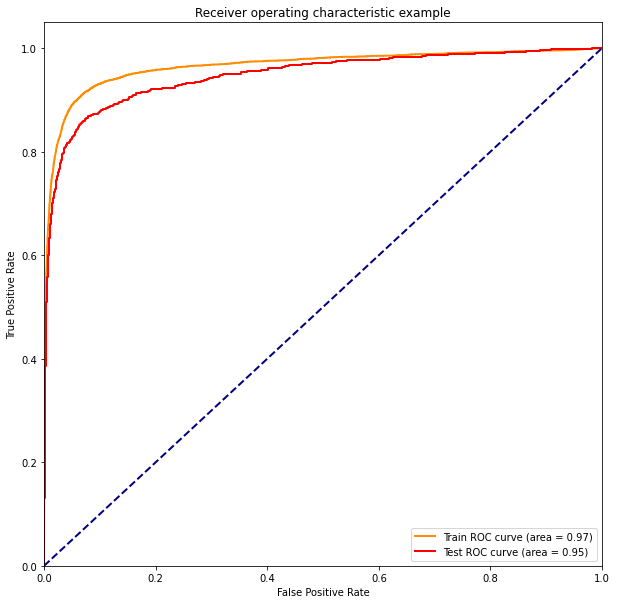

In [5]:
import os
import struct
import tensorflow as tf
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn import model_selection



def load_mnist(path, kind):
        
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                                 '%s-images.idx3-ubyte'
                                 % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                              dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                                  imgpath.read(16))
        images = np.fromfile(imgpath,
                                dtype=np.uint8).reshape(len(labels), 784)

    return images, labels
    
X_train, y_train = load_mnist('D:\Program Op\Jupyter\MNIST_data', 'train')
X_test, y_test = load_mnist('D:\Program Op\Jupyter\MNIST_data', 't10k')


# MNIST数据集中的部分数字图像
# X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 给训练集数据洗牌
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

y_train_5 = (y_train == 5)         # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)


sgd_clf = SGDClassifier(random_state=42)

# sgd_clf.fit(X_train, y_train_5)
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores1 = cross_val_predict(sgd_clf, X_test, y_test_5, cv=3, method="decision_function")

fpr,tpr,threshold = roc_curve(y_train_5, y_scores) ###计算真正率和假正率
fpr1,tpr1,threshold1 = roc_curve(y_test_5, y_scores1) ###计算真正率和假正率
roc_auc = auc(fpr,tpr) ###计算auc的值
roc_auc1 = auc(fpr1,tpr1) ###计算auc的值

ks = max(tpr-fpr)
ks1 = max(tpr1-fpr1)

plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='Train ROC curve (area = %0.2f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot(fpr1, tpr1, color='red',
            lw=lw, label='Test ROC curve (area = %0.2f)' % roc_auc1) ###假正率为横坐标，真正率为纵坐标做曲线
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()